# Data Story:
## Boston Health Inspections

The City of Boston, like many others, conducts health inspections of food service establishments in a largely random pattern of visits. But if we could estimate the probability that a health code violation will be found at a given food service establishment, then health inspections could be carried out, at least in part, by targeting the most likely suspects. This would make more efficient use of inspectors' time and, more importantly, increase the chances of detecting violations.

To devise a model for predicting where, are also when, health code violations might be expected, several sources of data may be used, but two of the most important are the following:
* City of Boston records (2006 to present), available from [data.cityofboston.gov](https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w), indicating some details about the outcomes of past health inspections.
+ City of Boston records of 311 service requests (2011 to present), available from [data.cityofboston.gov](https://data.cityofboston.gov/City-Services/311-Service-Requests/awu8-dc52), which include such details as rodent sightings and other "unsanitary conditions."

### Loading the data and cleaning it a bit
We will first load the data from health inspections and take a glimpse of a few randomly-selected inspections.

In [1]:
import pandas as pd
inspections = pd.read_csv(
    'data/Food_Establishment_Inspections.csv', 
    usecols = ['BusinessName', 'ISSDTTM', 'EXPDTTM', 'LICSTATUS', 'LICENSECAT',
       'DESCRIPT', 'RESULT', 'RESULTDTTM', 'Violation', 'ViolLevel',
       'ViolDesc', 'VIOLDTTM', 'ViolStatus', 'StatusDate', 'Comments', 'Location'
    ],
    parse_dates = ['ISSDTTM', 'EXPDTTM', 'RESULTDTTM', 'VIOLDTTM', 'StatusDate'], 
    infer_datetime_format = True
)
inspections.columns = [
    'name',           # business name
    'lic_issue',      # date of business license
    'lic_expire',     # expiration date of business license
    'lic_status',     # license status (active or inactive)
    'lic_category',   # license category ("FS", "FT", "RS", or "MFW")
    'type',           # more verbal description of license category 
    'result',         # result of the inspection (12 different possibilities)
    'result_date',    # date of inspection
    'violation',      # code for violation type
    'level',          # violation severity (can be * or ** or ***)
    'description',    # verbal description of violation
    'violation_date', # generally (or always?) the same as result_date
    'status',         # simply pass or fail
    'status_date',    # generally a day or so later than result_date, but often not given
    'comments',       # free-form text comments
    'location'        # (latitude, longitude)
]
inspections['location'] = inspections.location.str.strip('()')
inspections[['latitude','longitude']] = inspections['location'].apply(lambda x: pd.Series(str(x).split(',')))
inspections['latitude'] = pd.to_numeric(inspections.latitude, errors='coerce')
inspections['longitude'] = pd.to_numeric(inspections.longitude, errors='coerce')
inspections = inspections.drop('location', 1)
inspections = inspections[inspections.violation_date >= '2011-01-01 00:00:00']
inspections.sample(8)[['name', 'lic_category', 'type', 'result', 'result_date', 'description', 'status', 'comments']]

,name,lic_category,type,result,result_date,description,status,comments
135761,NOODLE STREET RESTAURANT,FS,Eating & Drinking,HE_Fail,2011-10-26 11:29:20,Hand Cleaner Drying Tissue Signage,Fail,NaN
402365,Baby Nats Fruitland,RF,Retail Food,HE_Fail,2013-05-30 14:53:34,Dressing Rooms Clean/Lockers Provided,Fail,Provide suitable lockers to store personal items.
296911,Chatime,FT,Eating & Drinking w/ Take Out,HE_Hearing,2016-01-13 10:44:22,Food Contact Surfaces Clean,Fail,PIC states at time of inspection that all drin...
132272,MORTON'S PIZZERIA,FS,Eating & Drinking,HE_Fail,2015-07-21 14:16:50,Cold Holding,Fail,Deli meats inside of the flip top cooler with ...
392499,Merkato Variety Store,RF,Retail Food,HE_Fail,2016-03-25 12:11:17,Food Container Labels,Fail,retail/provide proper labels name and address ...
334958,TAIWAN CAFE,FS,Eating & Drinking,HE_Fail,2014-04-01 11:34:26,Premises Maintained,Fail,Remove all unused & unnecessary articles
40038,Dozzi,FS,Eating & Drinking,HE_Fail,2013-09-18 11:41:36,Non-Food Contact Surfaces Clean,Fail,clean exterior of microwave. Clean cart near h...
98686,STEPHANIE'S,FS,Eating & Drinking,HE_Fail,2015-02-11 12:08:32,Inadequate Lighting,Fail,Kitchen -Repair non working light to vent hood.


The inspections dataset has somewhat more information than what we have loaded, but the other details do not seem as relevant. We have split the "location" column into separate latitude and longitude columns for convenience, and dropped any data from before 2011, since the next dataset does not extend back that far.

Now we will load the next dataset &mdash; information about 311 service request calls &mdash; and take a glimpse.

In [2]:
services = pd.read_csv(
    'data/311__Service_Requests.csv', 
    usecols = [
       'OPEN_DT', 'CLOSED_DT', 'CASE_STATUS', 'CLOSURE_REASON', 'CASE_TITLE', 'SUBJECT', 'REASON',
       'TYPE', 'Department', 'LATITUDE', 'LONGITUDE'
    ],
    parse_dates=['OPEN_DT', 'CLOSED_DT'], 
    infer_datetime_format = True
)
services.columns = [
    'open',         # date the complaint was registered
    'closed',       # date the complaint was resolved
    'status',       # open or closed
    'closure',      # details of how the complaint was closed (NaN if open)
    'title',        # description of the issue
    'subject',      # category of the issue (e.g. public works, civil rights, animal control, etc.)
    'reason',       # more specific category (often very similar to the "title")
    'type',         # usually identical to the "title" 
    'department',   # usually an abbreviation of the "subject"
    'latitude',      
    'longitude'      
]
services.sample(8)[['open', 'closed', 'title', 'subject', 'reason', 'type', 'department']]

,open,closed,title,subject,reason,type,department
722478,2016-02-24 15:56:00,2016-03-24 14:59:46,Unsatisfactory Living Conditions,Inspectional Services,Housing,Unsatisfactory Living Conditions,ISD
715692,2016-03-11 16:20:00,2016-03-14 08:33:56,Traffic Signal Inspection,Transportation - Traffic Division,Signs & Signals,Traffic Signal Inspection,BTDT
376873,2014-04-10 10:26:11,NaT,Other: Comment,Mayor's 24 Hour Hotline,Employee & General Comments,General Comments For a Program or Policy,INFO
742660,2016-04-21 07:47:00,2016-04-25 13:43:02,Contractor Complaints,Public Works Department,Highway Maintenance,Contractor Complaints,PWDx
635320,2012-09-23 14:13:03,2012-09-28 21:42:30,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,Schedule a Bulk Item Pickup,PWDx
577991,2015-09-09 07:41:35,2015-10-23 12:10:44,Rodent Activity,Inspectional Services,Environmental Services,Rodent Activity,ISD
191627,2011-12-21 11:50:00,2011-12-22 13:08:16,Request for Pothole Repair,Public Works Department,Highway Maintenance,Request for Pothole Repair,PWDx
765108,2016-05-25 07:47:07,2016-05-25 10:53:48,PWD Graffiti,Public Works Department,Highway Maintenance,PWD Graffiti,PWDx


This dataset also has more details than the ones loaded here.

### Big picture
The total number of observations in the inspection data from 2011 to present is almost a quarter million. About 4300 different establishments have been inspected, and practically all of them have experienced a "fail" inspection status at some point.  

In [3]:
len(inspections)

244297

In [4]:
len(inspections.name.unique())

4307

In [5]:
len(inspections[inspections.status == 'Fail'].name.unique())

4292

### Patterns in inspection failure rates
For the years 2011 through 2015, the number of inspections performed varies a great deal from month to month, but the *percentage* of inspections with a "fail" status is quite consistent.

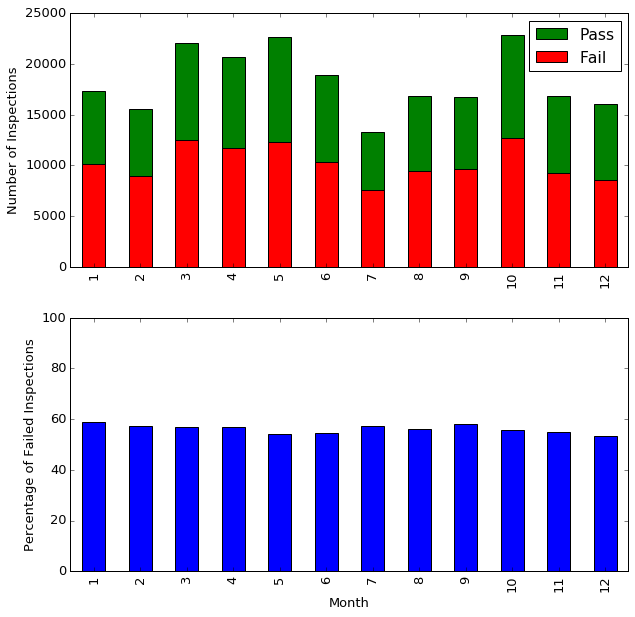

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 13
plt.subplot(2,1,1)
ax = inspections[
    inspections.violation_date <= '2015-12-31 00:00:00'
].result_date.dt.month.value_counts().sort_index().plot(kind = 'bar', color='green')
inspections[
    (inspections.status == 'Fail') & (inspections.violation_date <= '2015-12-31 00:00:00')
].result_date.dt.month.value_counts().sort_index().plot(kind = 'bar', ax = ax, color = 'red')
plt.legend(['Pass','Fail'])
plt.ylabel('Number of Inspections')
plt.subplot(2,1,2)
((
    (inspections[
            (inspections.status == 'Fail') & (inspections.violation_date <= '2015-12-31 00:00:00')
        ].result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[inspections.violation_date <= '2015-12-31 00:00:00'].result_date.dt.month.value_counts().sort_index())
)*100).plot(kind = 'bar', ylim=[0,100])
plt.xlabel('Month')
plt.ylabel('Percentage of Failed Inspections')

### Focusing on rodent issues
About 1500 establishments (35% of the total) have experienced inspection failures related to rodents.

In [23]:
len(inspections[
        (inspections.status == 'Fail') &
        (inspections.description.str.contains('odent'))
    ].name.unique())

1498

Inspections with rodent-related issues are an interesting subset of all inspections because we can investigate, relatively easily, whether citizens' reports of rodent sightings (through 311 service calls) are good predictors of subsequent rodent-related issues during health inspections of nearby food service establishments. 

#### Patterns in time

Intriguingly, based on service call data, rodents are reported via 311 most commonly around June to August, and are detected in health inspections most commonly shortly thereafter, in July to September. 

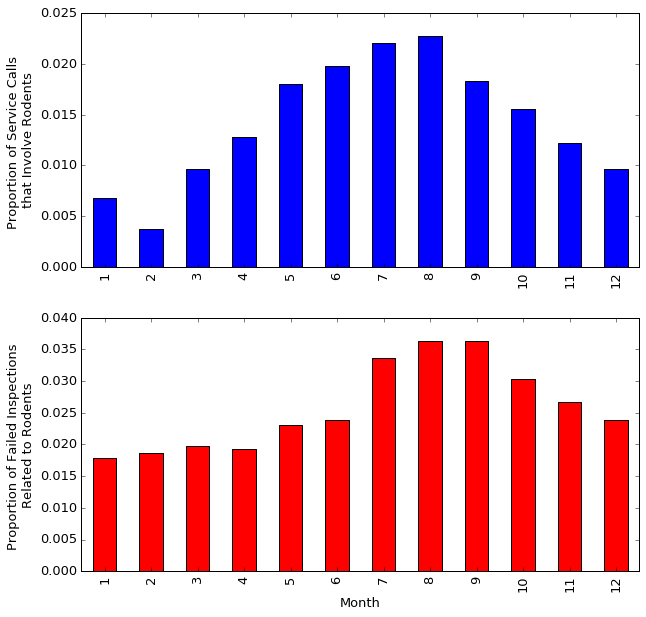

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 13
plt.subplot(2,1,1)
(
    services[services.title.fillna('').str.contains('odent')].open.dt.month.value_counts().sort_index()
    /
    services.open.dt.month.value_counts().sort_index()
).plot(kind = 'bar')
plt.ylabel('Proportion of Service Calls \nthat Involve Rodents')
plt.subplot(2,1,2)
(
    (inspections[
            (inspections.status=='Fail') &
            (inspections.description.str.contains('odent'))
        ].result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[inspections.status=='Fail'].result_date.dt.month.value_counts().sort_index())
).plot(kind = 'bar', color='red')
plt.xlabel('Month')
plt.ylabel('Proportion of Failed Inspections \nRelated to Rodents')

The pattern of a summer increase in public rodent sightings followed shortly thereafter by an increase in rodent-related inspection issues seems to repeat year after year.

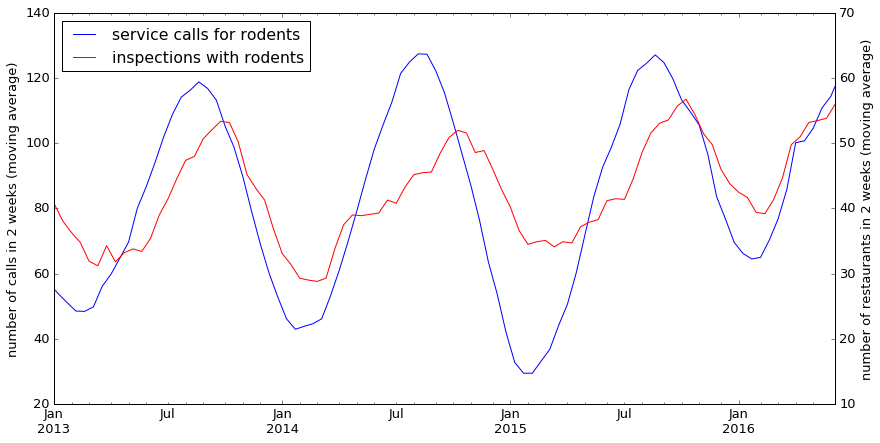

In [9]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 13
ax = services[services.title.fillna('').str.contains('odent')].set_index(
    'open'
)[['status']].rename(columns = {'status':'service calls for rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00']
)
plt.ylabel('number of calls in 2 weeks (moving average)')
inspections[inspections.description.fillna('').str.contains('odent')].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'inspections with rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00'], 
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')

On the other hand, for the *total number* of service calls, and *total* failed inspections, there is no cyclical pattern over time and no clear correlation between the two, except for the fact that both show an overall upward trend over time.

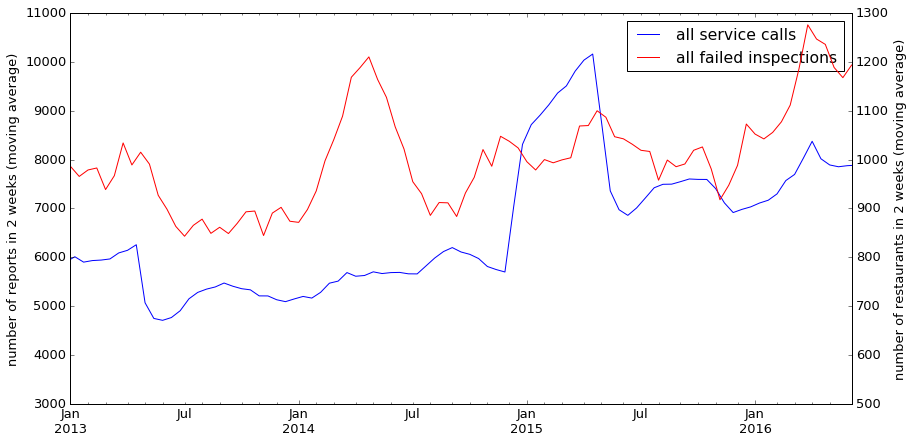

In [10]:
ax = services.set_index(
    'open'
)[['status']].rename(columns = {'status':'all service calls'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00']
)
plt.ylabel('number of reports in 2 weeks (moving average)')
inspections[inspections.status == 'Fail'].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'all failed inspections'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00'], 
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')

One cannot help but note the sudden rise in failed inspections around April 2014, and in service calls around February 2015. It would be interesting to know more about the nature of each of these anomalies.

#### Patterns in location

With some effort, we can use visuals to explore whether there might be a correlation between the locations of rodent sightings and of rodent-related inspection issues. For the graphs below, three different 7-day periods are selected (more or less at random) and service calls involving rodent activity during those periods are mapped. This reported rodent activity is indicated in green, with darker green corresponding to more activity. Then, rodent-related health inspections during a period starting two weeks later are shown in red. The length of delay between sightings and inspections is chosen somewhat arbitrarily, but in each case, the distributions of sightings and rodent-related inspection results do appear to be roughly similar. With further work, we might choose the length of delay more carefully, and adopt a more objective and numerical measure of this apparent correlation.

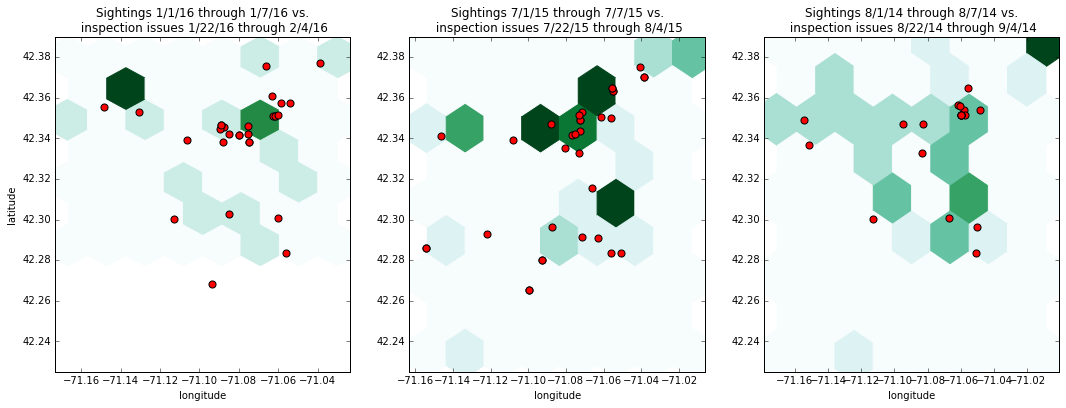

In [26]:
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 10
ax = plt.subplot(1,3,1)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2016-01-01 00:00:00' <= services.open) &
    (services.open <= '2016-01-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=[7,3],colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2016-01-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2016-02-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
ax.set_title('Sightings 1/1/16 through 1/7/16 vs.\n inspection issues 1/22/16 through 2/4/16')

ax = plt.subplot(1,3,2)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2015-07-01 00:00:00' <= services.open) &
    (services.open <= '2015-07-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False, ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2015-07-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2015-08-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 7/1/15 through 7/7/15 vs.\n inspection issues 7/22/15 through 8/4/15')


ax = plt.subplot(1,3,3)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2014-08-01 00:00:00' <= services.open) &
    (services.open <= '2014-08-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2014-08-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2014-09-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 8/1/14 through 8/7/14 vs.\n inspection issues 8/22/14 through 9/4/14')

We have focused here on just one aspect of health inspections, as a microcosm of the predictive relationship between service call data and inspection outcomes. The mostly visual exploration above gives good reason to believe that we might have some success predicting rodent-related inspection issues based on recent service calls for rodent activity. Extending this beyond rodents, by combining other aspects of the available service call data (along with other sources of data not explored here), we will construct a model for predicting the timing and location of a much broader variety of health inspection failures.